<a href="https://colab.research.google.com/github/Yong-Hui-Liew/PyTorch-Adventure/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Neural network classification with PyTorch

## 1. Make classification data and get it ready

In [2]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)  # random seed


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X\n: {X[:5]}")
print(f"First 5 samples of y\n: {y[:5]}")

First 5 samples of X
: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y
: [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


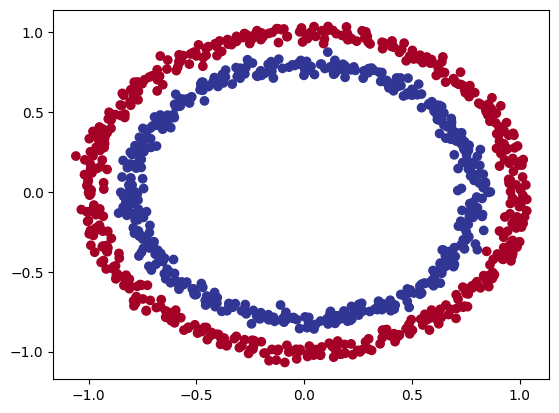

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

## 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train/test splits

In [8]:
import torch
torch.__version__

'2.3.0+cu121'

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)   # changing to default type within PyTorch
y = torch.from_numpy(y).type(torch.float)

In [11]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # random seed in `sklearn` code

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots

To do so, we want to:
1. Setup device agnostic code to run code on accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outline the forward pass (or forward computation) of the model
4. Instantiate an instance of our mode class and send it to the target `device`

In [14]:
import torch
from torch import nn

In [15]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # # 2. Create 2 nn.linear layers
    # self.layer_1 = nn.Linear(in_features=2, out_features=5)  # out_features generally multiple of 8
    # self.layer_2 = nn.Linear(in_features=5, out_features=1)

    self.two_linear_layers = nn.Sequential(    # Alternative
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

  # 3. Define forward() method
  def forward(self, x):
    return self.layer_2(self.layer1(x))   # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [16]:
device

'cuda'

In [17]:
next(model_0.parameters()).device   # check which device are the model parameters on

device(type='cuda', index=0)

In [18]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(   # This is fine, but we need to subclass nn.module manually to define our own forward() method,
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6617, -0.5288],
                      [ 0.2110,  0.5866],
                      [-0.5780,  0.3370],
                      [ 0.0640, -0.4163],
                      [ 0.2624,  0.2340]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2851, -0.6230, -0.6961, -0.4647, -0.1521], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3692, -0.0421, -0.0110, -0.4407, -0.1407]], device='cuda:0')),
             ('1.bias', tensor([-0.0963], device='cuda:0'))])

In [20]:
# Making predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.3923],
        [ 0.3584],
        [ 0.1779],
        [ 0.4543],
        [-0.3031],
        [-0.3200],
        [-0.0340],
        [-0.1941],
        [ 0.1985],
        [ 0.3509]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

For example for regression you might want MAE or MSE

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

And for optimizers, two of the most common and useful are SGD and Adam, but PyTorch have many other options

* For the loss function, we will use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on what a logit is in deep learning - https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow#:~:text=In%20context%20of%20deep%20learning,its%20input%20is%20logits%20layer.

In [21]:
# Setup the loss function
loss_fn = nn.BCELoss()  # Must go through sigmoid before passing it into this loss function
loss_fn = nn.BCEWithLogitsLoss()  # nn.Sigmoid() + nn.BCELoss() -> Increased numerical stability due to taking advantage of the log-sum-exp trick

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6617, -0.5288],
                      [ 0.2110,  0.5866],
                      [-0.5780,  0.3370],
                      [ 0.0640, -0.4163],
                      [ 0.2624,  0.2340]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2851, -0.6230, -0.6961, -0.4647, -0.1521], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3692, -0.0421, -0.0110, -0.4407, -0.1407]], device='cuda:0')),
             ('1.bias', tensor([-0.0963], device='cuda:0'))])

In [23]:
# Calculate accuracy = TP / (TP + TN) * 100
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

Build training loop (5 steps)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them into some activation function (e.g sigmoid for BCE and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits  # logits - not converted into predictions probailities yet

tensor([[ 0.3923],
        [ 0.3584],
        [ 0.1779],
        [ 0.4543],
        [-0.3031]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# Use sigmoid activation function on our model logits to turn them into prediction proabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5968],
        [0.5887],
        [0.5444],
        [0.6117],
        [0.4248]], device='cuda:0')

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs) # if y_pred_probs >= 0.5, `y=1`, else `y=0`

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))  # remove extra dimension (try without squeeze - it is okay)

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0')

### 3.2 Building a training and testing loop

In [28]:
X_test.shape, y_test.shape

(torch.Size([200, 2]), torch.Size([200]))

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()   # To remove the extra dimension so it is compatible with labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  # loss = loss_fn(y_pred, y_train) # for nn.BCELoss()
  loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss() expects raw logits (automatic sigmoid applied)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)  # test_logits is automatically converted into binaries similar to y_test
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test_loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70284, Acc: 50.38% | Test_loss: 0.70621, Test_acc: 51.50%
Epoch: 10 | Loss: 0.70040, Acc: 50.62% | Test_loss: 0.70363, Test_acc: 51.50%
Epoch: 20 | Loss: 0.69865, Acc: 50.62% | Test_loss: 0.70173, Test_acc: 51.50%
Epoch: 30 | Loss: 0.69736, Acc: 51.12% | Test_loss: 0.70030, Test_acc: 51.50%
Epoch: 40 | Loss: 0.69640, Acc: 51.25% | Test_loss: 0.69920, Test_acc: 50.50%
Epoch: 50 | Loss: 0.69566, Acc: 51.00% | Test_loss: 0.69835, Test_acc: 49.50%
Epoch: 60 | Loss: 0.69510, Acc: 50.62% | Test_loss: 0.69767, Test_acc: 49.00%
Epoch: 70 | Loss: 0.69467, Acc: 51.12% | Test_loss: 0.69714, Test_acc: 49.50%
Epoch: 80 | Loss: 0.69433, Acc: 51.00% | Test_loss: 0.69671, Test_acc: 50.00%
Epoch: 90 | Loss: 0.69406, Acc: 50.75% | Test_loss: 0.69637, Test_acc: 49.50%


## 4. Make predictions and evaluate the model

From the metric it looks like our model is not learning

To inspect, make some predictions and make them visual

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:   # wb: write permissions
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper function.py


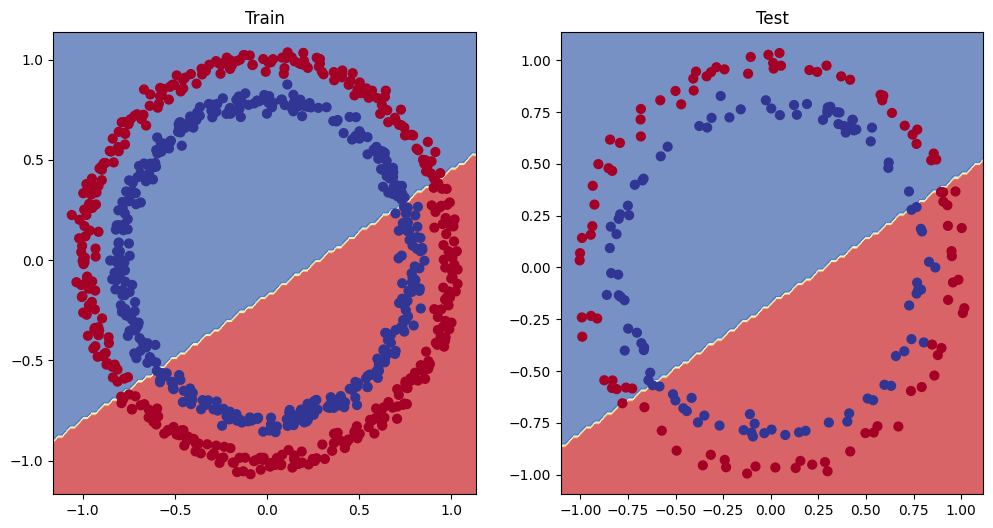

In [31]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These are also referred as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden unit: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000
* **Hint:** The linear model cannot fit non-linear data


In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [34]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [35]:
# Writing a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    acc = accuracy_fn(y_true=y_test,
                      y_pred=test_pred)
  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test_loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Acc: 51.00% | Test_loss: 0.69261, Test_acc: 49.00%
Epoch: 100 | Loss: 0.69305, Acc: 48.00% | Test_loss: 0.69379, Test_acc: 49.00%
Epoch: 200 | Loss: 0.69299, Acc: 46.00% | Test_loss: 0.69437, Test_acc: 49.00%
Epoch: 300 | Loss: 0.69298, Acc: 45.00% | Test_loss: 0.69458, Test_acc: 49.00%
Epoch: 400 | Loss: 0.69298, Acc: 46.00% | Test_loss: 0.69465, Test_acc: 49.00%
Epoch: 500 | Loss: 0.69298, Acc: 46.00% | Test_loss: 0.69467, Test_acc: 49.00%
Epoch: 600 | Loss: 0.69298, Acc: 46.00% | Test_loss: 0.69468, Test_acc: 49.00%
Epoch: 700 | Loss: 0.69298, Acc: 46.00% | Test_loss: 0.69468, Test_acc: 49.00%
Epoch: 800 | Loss: 0.69298, Acc: 46.00% | Test_loss: 0.69468, Test_acc: 49.00%
Epoch: 900 | Loss: 0.69298, Acc: 46.00% | Test_loss: 0.69468, Test_acc: 49.00%


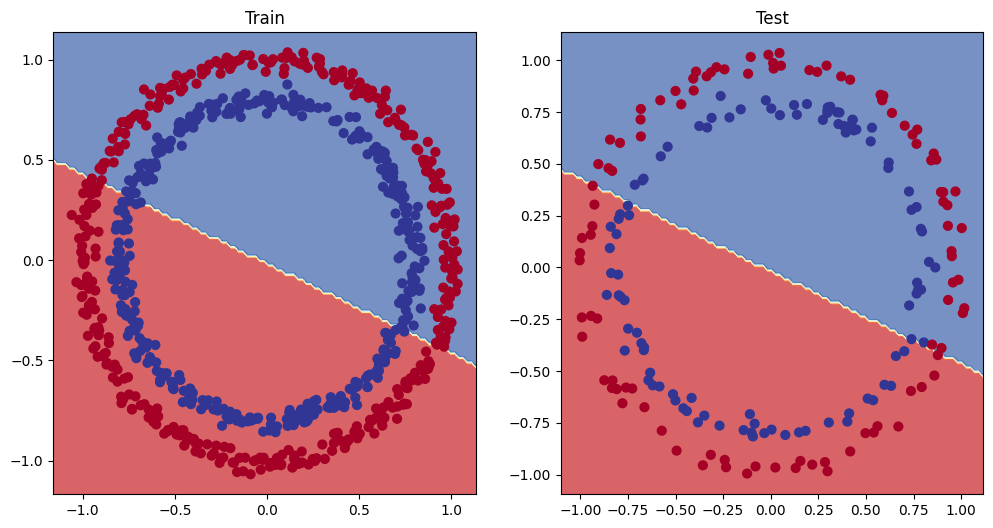

In [36]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

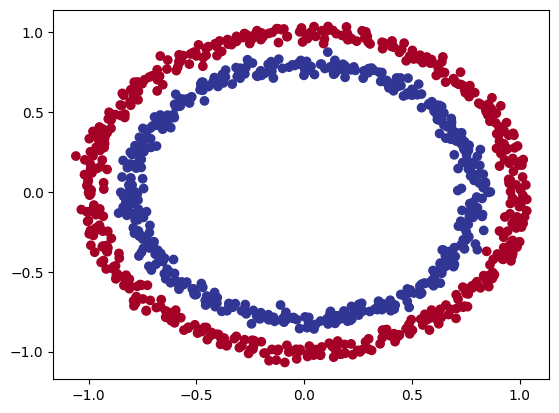

In [37]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [38]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### 6.2 Building a model with non-linearity

In [39]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
    # sigmoid applied later

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

In [40]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [41]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
    # 2. Calcuate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


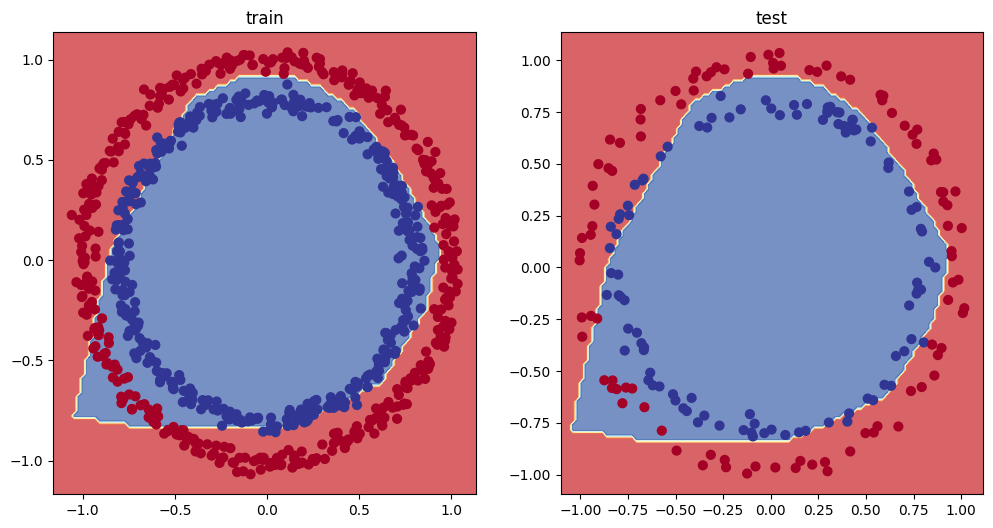

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

In [43]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

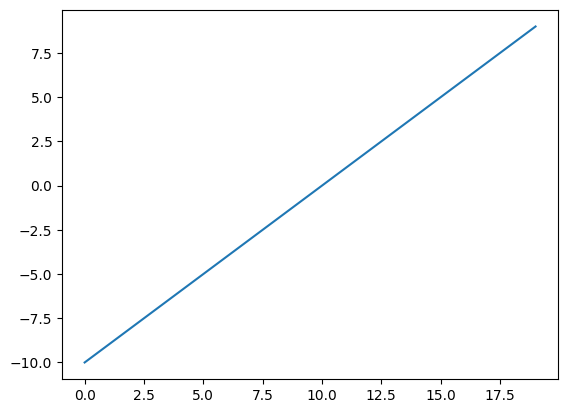

In [44]:
# Visualize the toy tensor
plt.plot(A);

In [45]:
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

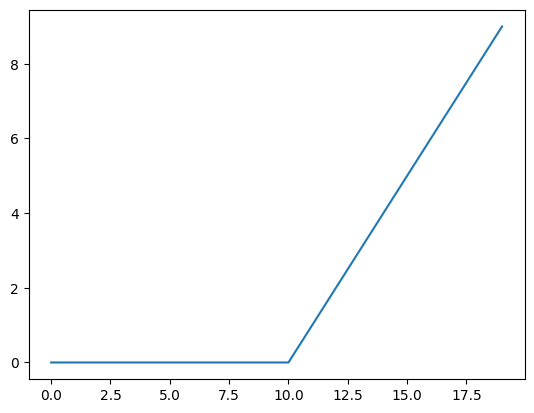

In [46]:
plt.plot(relu(A))

In [47]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

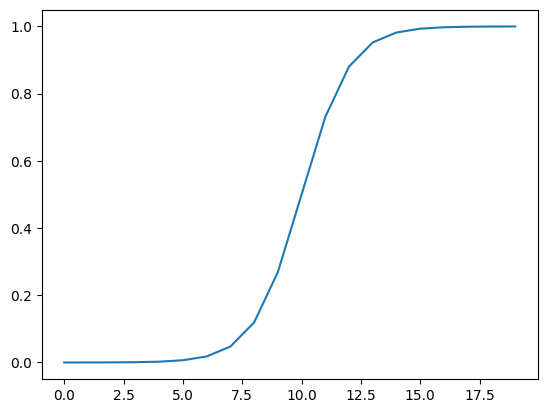

In [48]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy multi-class dataset

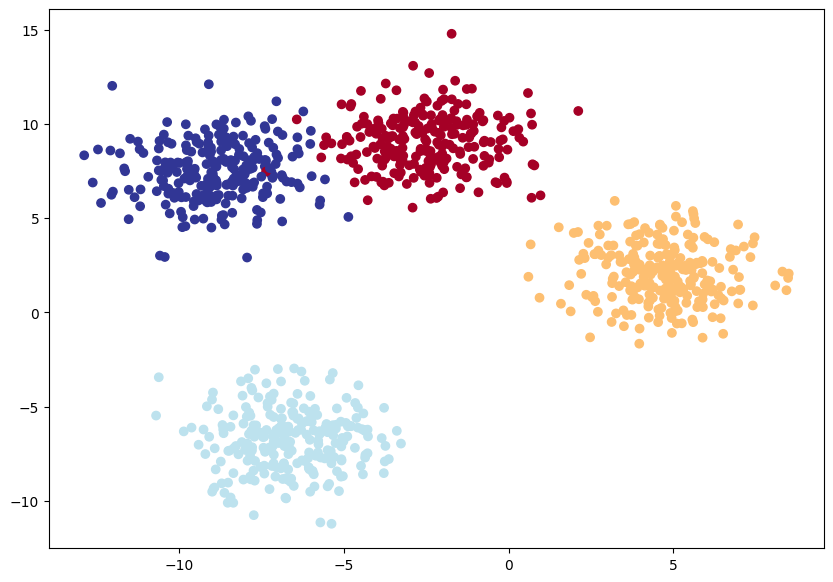

In [49]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation (common to capitalize)
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # X features
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
                            random_state=RANDOM_SEED)
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)   # 1. sklearn uses numpy by default, so we need to convert to tensor, 2. numpy uses float64 and tensors use float32 by default
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)  # indices requires `long` datatype (print y_blob to see it)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [50]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [52]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [53]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [54]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [55]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [56]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [57]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [58]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [59]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


Let's visualize them with `plot_decision_boundary()`, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (`plot_decision_boundary()` does this automatically for us).


**Note:** We did not use ReLU function (only 4 linear lines)

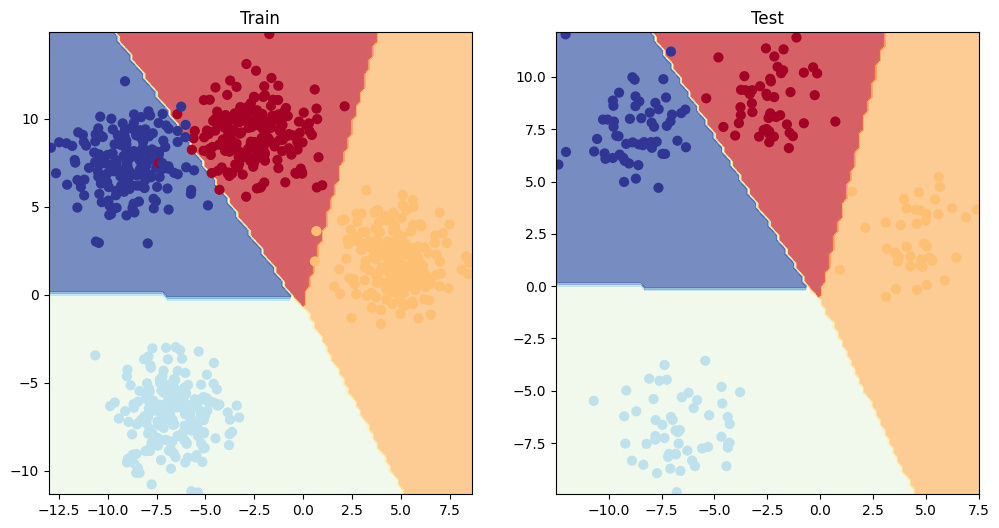

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

In [61]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

tensor(0.9950, device='cuda:0')